Borrowing heavily from https://casmls.github.io/general/2016/10/02/abc.html, instead of the variational objective we use a Stein Variational Gradient Descent.

The idea behind ABC is simply to replace an intractable likelihood with an estimate based on the distance between two datasets. Because time series have a natural ordering, given two data sets 

$$d_1,d_2,...,d_T$$
$$d'_1,d'_2,...,d'_T$$

We can easily compute the distance $K(\vec{d},\vec{d'})$ under a Gaussian kernel to get an estimate of the distance between the two datasets (unlike, say, an unordered dataset which would require a summary statistic since any permutation of the dataset would be valid) 


In order to evaluate the validity of such an approach we attempt to replicate some results found here:
http://kingaa.github.io/short-course/measles/measles.html

where the authors discover that particle based methods lead to poor estimate of $R_0$.


We first load the data (originally purposed for R) into python.




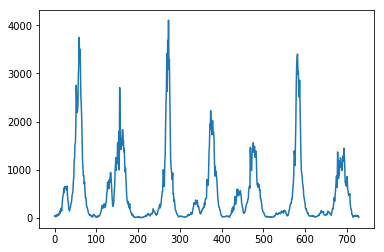

In [1]:
with open("/Users/gcgibson/Stein-Variational-Gradient-Descent/python/dat.json") as f:
    dat = f.read()
    
    
    dat = dat.split(",")
    time = []
    cases = []
    count = 0
    for elm in dat:
        if count % 2 ==0:
            time.append(elm.split(":")[1])
        else:
            cases.append(int(elm.split(":")[1].replace("}","").replace(']"]\n',"")))
        count +=1
        
import matplotlib.pyplot as plt

plt.plot(cases)
plt.show()

cases_per_season = np.split(cases,int(len(cases)/110))



Seasonal SIR model taken from http://www.princeton.edu/~dobber/pub/Altizer_etal_EcolLtrs2006.pdf

In a first pass we choose to ignore the covariates and simply consider the SEIR model.

We first define a code block that is able to simulate trajectories from the SEIR model.


(1.3076923076923077, 0.07692307692307693)


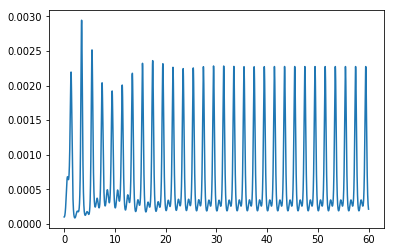

In [2]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt




def diff_eqs(INP,t,beta0,beta1, gamma,mu):  
    '''The main set of equations'''
    Y=np.zeros((3))
    V = INP   
    beta=beta0*(1+beta1*np.sin(2*np.pi*t/365))
    Y[0] = mu - beta*V[0]*V[1] - mu*V[0]
    Y[1] = beta*V[0]*V[1] - mu*V[1] - gamma*V[1]
    Y[2] = gamma * V[1] - mu * V[2]
    return Y   # For odeint


def simulator(beta,gamma):
    beta = np.exp(beta)
    gamma = np.exp(gamma)
    
    beta0=beta
    
    beta1=0.1
    print (beta0,gamma)
    
    mu=1./(50*365);
    S0=1./17;
    I0=1e-4;
    INPUT=np.array((S0,I0, 1-S0-I0))

    ND=MaxTime= 60*365;
    TS=1.0
    t_start = 0.0; t_end = ND; t_inc = TS
    t_range = np.arange(t_start, t_end+t_inc, t_inc)
    RES = spi.odeint(diff_eqs,INPUT,t_range,args=(beta0,beta1, gamma,mu))
    return RES[1:,1]

t=(np.arange(60*365)/365.)

plt.plot(t,simulator(np.log(17./13),np.log(1./13)))
plt.show()

With an ability to sample from a deterministic SIR model, we can now use this as a plugin estimate of the likelihood under ABC. We implement the ABC-SMC sampler as in Toni et all 2009 in order to efficiently generate samples from the posterior.




In [149]:
##population ABC
import numpy as np
from numpy.random import choice
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import uniform
import copy


#np.linspace(.5,.01,50)
def sample_kernel():
    return np.random.normal(0,.5)

def kernel_density(x,y):
    return norm.pdf(x,loc=y,scale=.5)
    
def prior_sample():
    return np.random.normal(0,1)

def prior_density(x):
    return norm.pdf(x, loc=0, scale=1)

def compute_distance(sim,cases):
    return np.power(sim-cases,2).sum()

print compute_distance(simulator(1,.5),simulator(1,.5))

N = 10
etols = [.0001,.00001]
current_weights = np.ones(N)/N
current_pop = []
t  = 0
for tol in etols:
    print (tol)
    if t == 0:
        while len(current_pop) < N:
            possible_sample = prior_sample()
            dist = compute_distance(simulator(possible_sample,-.1),simulator(.2,-.1))
            if dist < tol:
                print (possible_sample,dist)
                current_pop.append(possible_sample)
        t +=1
    else:
        #print current_weights
        previous_weights = copy.copy(current_weights)
        previous_pop = copy.copy(current_pop)
        tmp = []
        while len(tmp)< N:
            index = choice(range(N), 1, p=previous_weights)[0]
            possible_sample = current_pop[index] + sample_kernel()
            dist = compute_distance(simulator(possible_sample,-.1),simulator(.2,-.1))
            #print (possible_sample,dist)
            if dist < tol:
                #print (possible_sample,dist)
                tmp.append(possible_sample)
        current_pop = tmp
        #print (tmp)
        for i in range(len(tmp)):
            normalizer = 0
            for j in range(N):
                normalizer += previous_weights[j]*kernel_density(current_pop[i],previous_pop[j])
           # print (prior_density(previous_pop[i]),normalizer)
            current_weights[i] = prior_density(current_pop[i])/normalizer
        current_weights = current_weights/np.sum(current_weights)
            

0.0
0.0001
(0.20022415718326164, 2.8862712569525928e-08)
(0.2098265783027532, 5.6842924639324703e-05)
(0.19854411856549556, 1.2166324099139577e-06)
(0.1935269480327476, 2.355940739464292e-05)
(0.20039733187820555, 9.124966054345815e-08)
(0.19784189876473615, 2.653551993168493e-06)
(0.19503934295546815, 1.3946253054065038e-05)
(0.20876095089392716, 4.5016197669145216e-05)
(0.18974785560374113, 5.809334830582718e-05)
(0.20048059393218823, 1.3336457551986713e-07)
1e-05
(0.19864267012132666, 1.051669204004037e-06)
(0.19682026648562162, 5.753097802977768e-06)
(0.2029301825938473, 4.967782044003074e-06)
(0.20283204925471005, 4.639591520666917e-06)
(0.20134525211837856, 1.0425102698657016e-06)
(0.19891936042268357, 6.666125579808859e-07)
(0.20315112500772853, 5.748983548694487e-06)
(0.20158415955436382, 1.4464880059517409e-06)
(0.1988676899046741, 7.317556271481961e-07)
(0.19943548309989984, 1.8212123279723216e-07)


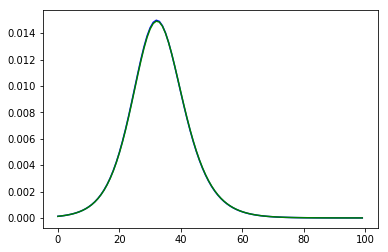

Beta :  0.20045196717650507
Gamma :  0.1
R_0 :  2.0045196717650504


In [150]:
current_pop = np.array(current_pop)

beta = np.average(current_pop,weights=current_weights)
plt.plot(simulator(beta,-.1),color='b')
plt.plot(simulator(.2,-.1),color='g')
plt.show()
#gamma = np.exp(np.mean(current_pop[:,1]*current_weights)) 
gamma = .1
print "log Beta : ", beta
print "Gamma : ",gamma
print "R_0 : ", beta/gamma

Now we have seen that the algorithm is able to recover the true parameter we are almost ready to try it on the measles case study. To help us choose good values of $\beta$ we need to make sure that the simulated data shares in some properties of the true cases. 

Let's plot the true cases again.

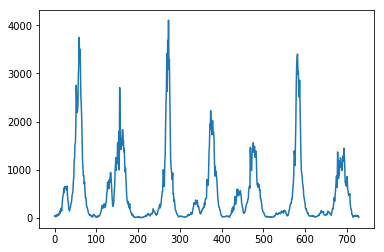

In [9]:
plt.plot(cases)
plt.show()

We notice we have about 7 peaks in the data with seasonality somewhwere just over 100. 

Lets see if we can get something similar out of the seasonal SIR model to get us going.

We have just over $700$ data points in the measles data so we are going to want to choose an evaluation range with just about the same number of points and a seasonality such that there about 7 peaks



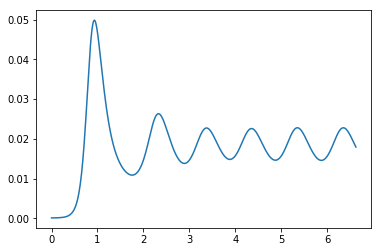

In [1]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt




def diff_eqs(INP,t,beta0,beta1, gamma,mu):  
    '''The main set of equations'''
    Y=np.zeros((3))
    V = INP   
    beta=beta0*(1+beta1*np.sin(2*np.pi*t/110))
    Y[0] = mu - beta*V[0]*V[1] - mu*V[0]
    Y[1] = beta*V[0]*V[1] - mu*V[1] - gamma*V[1]
    Y[2] = gamma * V[1] - mu * V[2]
    return Y   # For odeint


def simulator(beta,gamma):
    beta = np.exp(beta)
    gamma = np.exp(gamma)
    
    beta0=beta
    
    beta1=0.1
   # print (beta0,gamma)
    
    mu=1./(650);
    S0=1./17;
    I0=1e-4;
    INPUT=np.array((S0,I0, 1-S0-I0))

    ND=MaxTime= 730;
    TS=1.0
    t_start = 0.0; t_end = ND; t_inc = TS
    t_range = np.arange(t_start, t_end+t_inc, t_inc)
    RES = spi.odeint(diff_eqs,INPUT,t_range,args=(beta0,beta1, gamma,mu))
    return RES[1:,1]

t=(np.arange(730)/110.)

plt.plot(t,simulator(np.log(17./13),np.log(1./13)))
plt.show()

For demonstration purposes this looks like a good enough starting point. 

Choosing these params as an initial point gives us a distance of 

In [4]:
np.power(simulator(np.log(17./13),np.log(1./13))-cases,2).sum()

(1.3076923076923077, 0.07692307692307693)


565722113.9243002

Why is that so large? Well I is operating on the range[0,1] but cases is still in raw counts. Let's bring cases down to [0,1] and re-compute



In [8]:

normalized_cases = np.array(cases)/(1.0*np.max(cases))

np.power(simulator(np.log(17./13),np.log(1./13))-normalized_cases,2).sum()

30.66784019461778

That looks much more reasonable, we are ready to try PMC ABC!

In [31]:
##population ABC
import numpy as np
from numpy.random import choice
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import uniform
import copy
import sys


#np.linspace(.5,.01,50)
def sample_kernel():
    return np.random.normal(0,.5)

def kernel_density(x,y):
    return norm.pdf(x,loc=y,scale=.5)
    
def prior_sample():
    return np.random.normal(0,1)

def prior_density(x):
    return norm.pdf(x, loc=0, scale=1)

def compute_distance(sim,cases):
    return np.power(sim-cases,2).sum()

print compute_distance(simulator(np.log(17./13),np.log(1./13)),normalized_cases)

N = 1000
etols = [30]
current_weights = np.ones(N)/N
current_pop = []
t  = 0
for tol in etols:
    print (tol)
    if t == 0:
        while len(current_pop) < N:
            possible_sample = prior_sample()
            dist = compute_distance(simulator(possible_sample,np.log(1./13)),normalized_cases)
            if dist < tol:
                current_pop.append(possible_sample)
        t +=1
    else:
        #print current_weights
        previous_weights = copy.copy(current_weights)
        previous_pop = copy.copy(current_pop)
        tmp = []
        while len(tmp)< N:
            index = choice(range(N), 1, p=previous_weights)[0]
            possible_sample = current_pop[index] + sample_kernel()
            dist = compute_distance(simulator(possible_sample,np.log(1./13)),normalized_cases)
            if dist < tol:
                tmp.append(possible_sample)
        current_pop = tmp
        for i in range(len(tmp)):
            normalizer = 0
            for j in range(N):
                normalizer += previous_weights[j]*kernel_density(current_pop[i],previous_pop[j])
            current_weights[i] = prior_density(current_pop[i])/normalizer
        current_weights = current_weights/np.sum(current_weights)
            

30.66784019461778
30


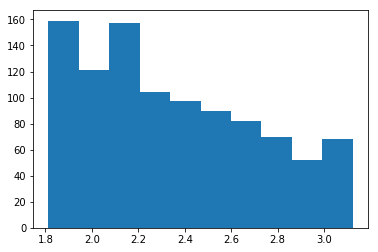

Beta :  2.320129751748928
Gamma :  0.0769230769231
R_0 :  30.161686772736065


In [34]:
current_pop = np.array(current_pop)

beta = np.exp(np.average(current_pop,weights=current_weights))
plt.hist(np.exp(current_pop))
plt.show()
#gamma = np.exp(np.mean(current_pop[:,1]*current_weights)) 
gamma = 1./13
print "Beta : ", beta
print "Gamma : ",gamma
print "R_0 : ", beta/gamma

So we are able to get an estimate of $R_0$ for a fixed gamma. in order to really make this useful we need to extend this to multidimensional paramater space. In particular, we really need proposals for both $\beta$ and $\gamma$


In [16]:
##population ABC
import numpy as np
from numpy.random import choice
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import uniform
import copy
import sys


prior_sd = .5

#np.linspace(.5,.01,50)
def sample_kernel():
    return np.random.normal(0,.5)

def kernel_density(x,y):
    return norm.pdf(x,loc=y,scale=.5)
    
def prior_sample():
    return np.random.normal(0,prior_sd)

def prior_density(x):
    return norm.pdf(x, loc=0, scale=prior_sd)

def compute_distance(sim,cases):
    return np.power(sim-cases,2).sum()

print compute_distance(simulator(np.log(17./13),np.log(1./13)),normalized_cases)

N = 100
etols = [33]
current_weights_beta = np.ones(N)/N
current_weights_gamma = np.ones(N)/N

current_pop_beta = []
current_pop_gamma = []
t  = 0
for tol in etols:
    print (tol)
    if t == 0:
        while len(current_pop_beta) < N:
            possible_sample_beta = prior_sample()
            possible_sample_gamma = prior_sample()
            dist = compute_distance(simulator( \
                            possible_sample_beta,possible_sample_gamma),normalized_cases)
            #print (possible_sample_beta,possible_sample_gamma,dist)
            if dist < tol:
                current_pop_beta.append(possible_sample_beta)
                current_pop_gamma.append(possible_sample_gamma)
        t +=1
    else:
        #print current_weights
        previous_weights_beta = copy.copy(current_weights_beta)
        previous_pop_beta = copy.copy(current_pop_beta)
        
        previous_weights_gamma = copy.copy(current_weights_gamma)
        previous_pop_gamma = copy.copy(current_pop_gamma)
        
        tmp_beta = []
        tmp_gamma = []
        while len(tmp)< N:
            index = choice(range(N), 1, p=previous_weights)[0]
            possible_sample = current_pop[index] + sample_kernel()
            dist = compute_distance(simulator(possible_sample,np.log(1./13)),normalized_cases)
            if dist < tol:
                tmp.append(possible_sample)
        current_pop = tmp
        for i in range(len(tmp)):
            normalizer = 0
            for j in range(N):
                normalizer += previous_weights[j]*kernel_density(current_pop[i],previous_pop[j])
            current_weights[i] = prior_density(current_pop[i])/normalizer
        current_weights = current_weights/np.sum(current_weights)
            

30.66784019461778
33


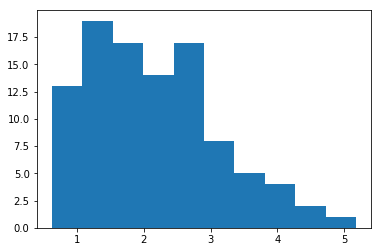

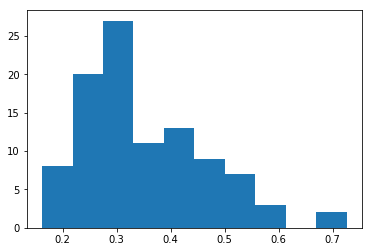

Beta :  1.9067060441145907
Gamma :  0.33657191914265344
R_0 :  5.665077612450633


In [17]:
current_pop_beta = np.array(current_pop_beta)
current_pop_gamma = np.array(current_pop_gamma)

beta = np.exp(np.average(current_pop_beta,weights=current_weights_beta))
gamma = np.exp(np.average(current_pop_gamma,weights=current_weights_gamma))

plt.hist(np.exp(current_pop_beta))
plt.show()

plt.hist(np.exp(current_pop_gamma))
plt.show()


print "Beta : ", beta
print "Gamma : ",gamma
print "R_0 : ", beta/gamma

Although this approach seems to do okay, we still get an unrealistic estimate for $R_0$. The question then becomes, can we use high dimensional sampling techniques to improve the estimate of $R_0$? Here we focus on Stein variational gradient descent given here:
https://github.com/DartML/Stein-Variational-Gradient-Descent


In order to compute the $dnlprob$ given in SVGD, we need to figure out how to take the derivative of the log probability.

What is the log-probability of the model? 

Well it is simply 

$$p(D,D' | \epsilon,\theta) p(\theta)$$

To start with we follow https://casmls.github.io/general/2016/10/02/abc.html and replace the probability with a normal kernel 

$$p(D,D' | \epsilon,\theta) = N(D | D',\epsilon, \theta)$$ 




In [ ]:
import numpy as np
import numpy.matlib as nm
from svgd import SVGD

class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)
    
if __name__ == '__main__':
    A = np.array([[0.2260,0.1652],[0.1652,0.6779]])
    mu = np.array([-0.6871,0.x`8010])
    
    model = MVN(mu, A)
    
    x0 = np.random.normal(0,1, [10,2]);
    theta = SVGD().update(x0, model.dlnprob, n_iter=1000, stepsize=0.01)
    
    print "ground truth: ", mu
    print "svgd: ", np.mean(theta,axis=0)

In order to use
this we need to write down the gradient of the likelihood which can be done in autograd if we can take the derivative with respect to the parameters.

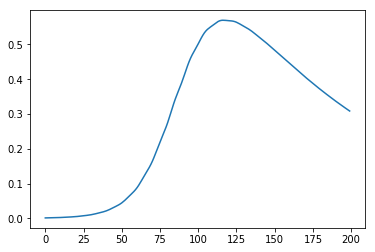

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [23]:
with open("/Users/gcgibson/Stein-Variational-Gradient-Descent/python/dat.json") as f:
    dat = f.read()
    
    
    dat = dat.split(",")
    time = []
    cases = []
    count = 0
    for elm in dat:
        if count % 2 ==0:
            time.append(elm.split(":")[1])
        else:
            cases.append(int(elm.split(":")[1].replace("}","").replace(']"]\n',"")))
        count +=1

import autograd.numpy as np   # Thinly-wrapped version of Numpy
import autograd.scipy as scipy
import matplotlib.pyplot as plt

from autograd import grad,jacobian,elementwise_grad

beta0 = .1

def fa(a,b,c,alpha,beta):
    return -beta*a*b
def fb(a,b,c,alpha,beta):
    return beta*a*b - alpha*b
def fc(a,b,c,alpha,beta):
    return alpha*b

def rK3(a, b, c, fa, fb, fc, hs,alpha,beta,t):
    beta=beta*(1+.1*np.sin(2*np.pi*t/10))
   
    
    a1 = fa(a, b, c, alpha, beta)*hs
    b1 = fb(a, b, c, alpha, beta)*hs
    c1 = fc(a, b, c, alpha, beta)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(ak, bk, ck, alpha, beta)*hs
    b2 = fb(ak, bk, ck, alpha, beta)*hs
    c2 = fc(ak, bk, ck, alpha, beta)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(ak, bk, ck, alpha, beta)*hs
    b3 = fb(ak, bk, ck, alpha, beta)*hs
    c3 = fc(ak, bk, ck, alpha, beta)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(ak, bk, ck, alpha, beta)*hs
    b4 = fb(ak, bk, ck, alpha, beta)*hs
    c4 = fc(ak, bk, ck, alpha, beta)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

def forward_sample(theta):
    alpha = theta[0]
    beta = theta[1]
    a, b, c, hs = .9, .001, 0, 0.05
    a_arr = []
    b_arr = []
    c_arr = []
    for i in range(200):
        a, b, c = rK3(a, b, c, fa, fb, fc, hs, alpha, beta,i)
        a_arr.append(a)
        b_arr.append(b)
        c_arr.append(c)
    return b_arr

d2 = forward_sample([.2,1.9])
plt.plot(d2)
plt.show()
def distance_abc(theta):
   # print (np.mean(np.power((np.array(b_arr)-np.array(cases[:200])),2)))
    return np.exp(-np.mean(np.power((np.array(forward_sample(theta))-np.array(d2)),2)))
    

grad_abc = elementwise_grad(distance_abc)

def get_grad(a,b):
    tmp = grad_abc([a,b])
    return [tmp[0].tolist(),tmp[1].tolist()]




from scipy.spatial.distance import pdist, squareform


def svgd_kernel( theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
 

x0 = np.random.normal(0,1, [10,2]);
n_iter = 100
stepsize=0.01
bandwidth = -1
alpha = 0.9
        # Check input

        
theta = np.copy(x0) 
        
        # adagrad with momentum
fudge_factor = 1e-6
historical_grad = 0

for iter in range(n_iter):
            print (iter)
            
            lnpgrad = []
            for t in theta:
                lnpgrad.append(get_grad(np.exp(t[0]),np.exp(t[1])) )
            # calculating the kernel matrix
            kxy, dxkxy = svgd_kernel(theta, h = -1)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
            
    

In [24]:

print "beta hat : ",(np.exp(np.mean(theta[:,1
    ])))

print "gamma hat : ",(np.exp(np.mean(theta[:,0
    ])))



beta hat :  0.621272616043221
gamma hat :  0.9310325203363019


In [46]:
distance_abc([.1,.1])

def log_density(x, t):
        mu, log_sigma = x[0], x[1]
        sigma_density = norm.logpdf(log_sigma, 0, 1.35)
        mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
        return sigma_density + mu_density

log_density([.1,.1],0)

0.8771202903774759

Unfortunately, this doesn't seem to work very well so we employ BBVI


In [17]:

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad
from autograd.misc.optimizers import adam
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

D = 2
def log_density(x, t):
    ret_arr = []
    for x_ in x:
        ret_arr.append(np.log(distance_abc(np.exp(x_))) )
    print (np.array(ret_arr).shape)
    return np.array(ret_arr ) + -.5*(x[:,0])^2 +-.5*(x[:,1])^2

objective, gradient, unpack_params = \
        black_box_variational_inference(log_density, D, num_samples=10)

print("Optimizing variational parameters...")
init_mean    = -1 * np.ones(D)
init_log_std = -5 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=200)


Optimizing variational parameters...
(10,)


TypeError: unsupported operand type(s) for ^: 'ArrayBox' and 'ArrayBox'

In [13]:
print (np.exp(variational_params))

[nan nan nan nan]


This also doesn't seem to work, so we start looking at PYMC3

In [18]:
from theano import scan
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution


class CAR(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : list of adjacency information
    w : list of weight information
    tau : precision at each location
    """
    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def get_mu(self, x):

        def weigth_mu(w, a):
            a1 = tt.cast(a, 'int32')
            return tt.sum(w*x[a1])/tt.sum(w)

        mu_w, _ = scan(fn=weigth_mu,
                       sequences=[self.w, self.a])

        return mu_w

    def logp(self, x):
        mu_w = self.get_mu(x)
        tau = self.tau
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))


/Users/gcgibson/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/gcgibson/anaconda/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
  0%|          | 0/3000 [00:00<?, ?it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x10b0cc430, file "/Use...2.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/Users/gcgib...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x10b0cc430, file "/Use...2.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/Users/gcgib...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 14, 22, 47, 18, 213245, tzinfo=tzutc()), u'msg_id': u'A71DA3EDD427463280A442C4844F8C88', u'msg_type': u'execute_request', u'session': u'94637B475E654C6884D86DFF0829DC0C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'A71DA3EDD427463280A442C4844F8C88', 'msg_type': u'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['94637B475E654C6884D86DFF0829DC0C']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 14, 22, 47, 18, 213245, tzinfo=tzutc()), u'msg_id': u'A71DA3EDD427463280A442C4844F8C88', u'msg_type': u'execute_request', u'session': u'94637B475E654C6884D86DFF0829DC0C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'A71DA3EDD427463280A442C4844F8C88', 'msg_type': u'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['94637B475E654C6884D86DFF0829DC0C'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 14, 22, 47, 18, 213245, tzinfo=tzutc()), u'msg_id': u'A71DA3EDD427463280A442C4844F8C88', u'msg_type': u'execute_request', u'session': u'94637B475E654C6884D86DFF0829DC0C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'A71DA3EDD427463280A442C4844F8C88', 'msg_type': u'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Import object>, <_ast.Import object>, <_ast.Import object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.With object>, <_ast.Expr object>], cell_name='<ipython-input-18-cdbbf64882f2>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 122391950, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1215a21b0, file "<ipython-input-18-cdbbf64882f2>", line 9>
        result = <ExecutionResult object at 122391950, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1215a21b0, file "<ipython-input-18-cdbbf64882f2>", line 9>, result=<ExecutionResult object at 122391950, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1215a21b0, file "<ipython-input-18-cdbbf64882f2>", line 9>
        self.user_global_ns = {'D': 2, 'In': ['', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'print (variational_params)', u'print (np.exp(variational_params))', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'print (np.exp(variational_params))', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'print (np.exp(variational_params))', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)"], 'Out': {}, '_': '', '__': '', '___': '', '__builtin__': <module '__builtin__' (built-in)>, '__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', '__name__': '__main__', ...}
        self.user_ns = {'D': 2, 'In': ['', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'\nimport autograd.numpy as np\nimport autograd...t, init_var_params, step_size=0.1, num_iters=20)', u'print (variational_params)', u'print (np.exp(variational_params))', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'print (np.exp(variational_params))', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'print (np.exp(variational_params))', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u'\nimport autograd.numpy as np\nimport autograd..., init_var_params, step_size=0.1, num_iters=200)', u"import pymc3 as pm\nimport numpy as np\nimport...e(2000, tune=1000, njobs=4)\npm.traceplot(trace)"], 'Out': {}, '_': '', '__': '', '___': '', '__builtin__': <module '__builtin__' (built-in)>, '__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', '__name__': '__main__', ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/gcgibson/abc/<ipython-input-18-cdbbf64882f2> in <module>()
     19         alpha = loc - scale / c
     20         bounds = tt.switch(value > 0, value > alpha, value < alpha)
     21         return bound(logp, bounds, c != 0)
     22 
     23     gev = pm.DensityDist('gev', gev_logp, observed=data)
---> 24     trace = pm.sample(2000, tune=1000, njobs=4)
     25 pm.traceplot(trace)

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/pymc3/sampling.py in sample(draws=3000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'c_logodds__': array(-0.72837105)}, {'c_logodds__': array(-1.29727189)}, {'c_logodds__': array(-1.25065699)}, {'c_logodds__': array(-0.88153034)}], trace=None, chain=0, njobs=4, tune=1000, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=-1, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, **kwargs={})
    280     else:
    281         sample_func = _sample
    282 
    283     discard = tune if discard_tuned_samples else 0
    284 
--> 285     return sample_func(**sample_args)[discard:]
        sample_func = <function _mp_sample>
        sample_args = {'chain': 0, 'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 4, 'progressbar': True, 'random_seed': -1, 'start': [{'c_logodds__': array(-0.72837105)}, {'c_logodds__': array(-1.29727189)}, {'c_logodds__': array(-1.25065699)}, {'c_logodds__': array(-0.88153034)}], 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, ...}
        discard = 1000
    286 
    287 
    288 def _check_start_shape(model, start):
    289     e = ''

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})
    498     pbars = [kwargs.pop('progressbar')] + [False] * (njobs - 1)
    499     traces = Parallel(n_jobs=njobs)(delayed(_sample)(chain=chains[i],
    500                                                      progressbar=pbars[i],
    501                                                      random_seed=rseed[i],
    502                                                      start=start_vals[i],
--> 503                                                      **kwargs) for i in range(njobs))
        kwargs = {'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000}
        njobs = 4
    504     return merge_traces(traces)
    505 
    506 
    507 def stop_tuning(step):

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Feb 14 17:48:14 2018
PID: 17817               Python 2.7.13: /Users/gcgibson/anaconda/bin/python
...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = ()
        kwargs = {'chain': 0, 'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 1803003819, 'start': {'c_logodds__': array(-0.72837105)}, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, ...}
        self.items = [(<function _sample>, (), {'chain': 0, 'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 1803003819, 'start': {'c_logodds__': array(-0.72837105)}, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, ...})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/pymc3/sampling.py in _sample(draws=3000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'c_logodds__': array(-0.72837105)}, trace=None, chain=0, tune=1000, progressbar=True, model=<pymc3.model.Model object>, random_seed=1803003819, live_plot=False, live_plot_kwargs=None, **kwargs={})
    327                             tune, model, random_seed)
    328     if progressbar:
    329         sampling = tqdm(sampling, total=draws)
    330     try:
    331         strace = None
--> 332         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/3000 [00:01<?, ?it/s]
    333             if live_plot:
    334                 if live_plot_kwargs is None:
    335                     live_plot_kwargs = {}
    336                 if it >= skip_first:

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/3000 [00:01<?, ?it/s])
    948             except AttributeError:
    949                 raise TqdmDeprecationWarning("""\
    950 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    951 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    952 
--> 953             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    954                 yield obj
    955                 # Update and possibly print the progressbar.
    956                 # Note: does not call self.update(1) for speed optimisation.
    957                 n += 1

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/pymc3/sampling.py in _iter_sample(draws=3000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'c_logodds__': array(-0.72837105)}, trace=None, chain=0, tune=1000, model=<pymc3.model.Model object>, random_seed=1803003819)
    425     try:
    426         for i in range(draws):
    427             if i == tune:
    428                 step = stop_tuning(step)
    429             if step.generates_stats:
--> 430                 point, states = step.step(point)
        point = {'c_logodds__': array(-0.72837105)}
        states = undefined
        step.step = <bound method NUTS.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    431                 if strace.supports_sampler_stats:
    432                     strace.record(point, states)
    433                 else:
    434                     strace.record(point)

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'c_logodds__': array(-0.72837105)})
    170     def step(self, point):
    171         self._logp_dlogp_func.set_extra_values(point)
    172         array = self._logp_dlogp_func.dict_to_array(point)
    173 
    174         if self.generates_stats:
--> 175             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method NUTS.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([-0.72837105])
    176             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    177             return point, stats
    178         else:
    179             apoint = self.astep(array)

...........................................................................
/Users/gcgibson/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([-0.72837105]))
    177         p0 = self.potential.random()
    178         start = self.integrator.compute_state(q0, p0)
    179 
    180         if not np.isfinite(start.energy):
    181             raise ValueError('Bad initial energy: %s. The model '
--> 182                              'might be misspecified.' % start.energy)
        start.energy = inf
    183 
    184         if not self.adapt_step_size:
    185             step_size = self.step_size
    186         elif self.tune:

ValueError: Bad initial energy: inf. The model might be misspecified.
___________________________________________________________________________

stillllllllllll doesn't work aaaaaaahhhhhhhhhh
lets try scrapping autograd cuz it sucks and just do out the derivatives

In [65]:
with open("/Users/gcgibson/Stein-Variational-Gradient-Descent/python/dat.json") as f:
    dat = f.read()
    
    
    dat = dat.split(",")
    time = []
    cases = []
    count = 0
    for elm in dat:
        if count % 2 ==0:
            time.append(elm.split(":")[1])
        else:
            cases.append(int(elm.split(":")[1].replace("}","").replace(']"]\n',"")))
        count +=1



beta0 = .1

def fa(a,b,c,alpha,beta):
    return -beta*a*b
def fb(a,b,c,alpha,beta):
    return beta*a*b - alpha*b
def fc(a,b,c,alpha,beta):
    return alpha*b

def rK3(a, b, c, fa, fb, fc, hs,alpha,beta,t):
    beta=beta*(1+.1*np.sin(2*np.pi*t/10))
   
    
    a1 = fa(a, b, c, alpha, beta)*hs
    b1 = fb(a, b, c, alpha, beta)*hs
    c1 = fc(a, b, c, alpha, beta)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(ak, bk, ck, alpha, beta)*hs
    b2 = fb(ak, bk, ck, alpha, beta)*hs
    c2 = fc(ak, bk, ck, alpha, beta)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(ak, bk, ck, alpha, beta)*hs
    b3 = fb(ak, bk, ck, alpha, beta)*hs
    c3 = fc(ak, bk, ck, alpha, beta)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(ak, bk, ck, alpha, beta)*hs
    b4 = fb(ak, bk, ck, alpha, beta)*hs
    c4 = fc(ak, bk, ck, alpha, beta)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

def forward_sample(theta):
    alpha = theta[0]
    beta = theta[1]
    a, b, c, hs = .9, .001, 0, 0.05
    a_arr = []
    b_arr = []
    c_arr = []
    for i in range(200):
        a, b, c = rK3(a, b, c, fa, fb, fc, hs, alpha, beta,i)
        a_arr.append(a)
        b_arr.append(b)
        c_arr.append(c)
    return b_arr

import emcee
from scipy.stats import norm
d2 = forward_sample([.2,1.9])

def distance_abc(theta):
   # print (np.mean(np.power((np.array(b_arr)-np.array(cases[:200])),2)))
    tmp = -np.sum(np.power((np.array(forward_sample(np.exp(theta)))-np.array(d2)),2))
    #print (tmp + norm.logpdf(theta,0,1) )
    ret_val = tmp + norm.logpdf(theta,0,1)
    if np.isnan(ret_val).any():
        ret_val = -10000000*np.ones(2)
    #print (ret_val.shape)
    return ret_val.sum()

ndim, nwalkers = 2, 10
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, distance_abc)
sampler.run_mcmc(p0, 1000)


(array([[-1.528013  ,  0.63631756],
        [-1.70417598,  0.67807913],
        [-1.44791402,  0.6698845 ],
        [-1.77713708,  0.5676186 ],
        [-1.4073692 ,  0.75000873],
        [-1.51501144,  0.5870013 ],
        [-1.68185197,  0.77928098],
        [-1.36437767,  0.6601509 ],
        [-1.74249793,  0.83120308],
        [-1.6255246 ,  0.67693288]]),
 array([-3.31902091, -3.85684521, -3.53738014, -4.42996141, -4.83789301,
        -3.75321833, -5.88087635, -3.88515514, -8.09196424, -3.54751761]),
 ('MT19937', array([ 238201290, 3693368058, 3748790146, 2345021304, 3662484617,
         2401907341, 1454731844, 1547579254,  677491715, 3903481393,
         2858173250, 2677902625,  218634075, 3845976161, 3998236456,
         4288999150,  392117472, 3701575584,  269393606,  241380541,
          222808041, 1330291837, 1753911496, 4275306733, 1121334240,
          733638996, 1116037906, 1623486352, 3875018732,  868623505,
          362873399,  717162830, 3871808473, 1549334138, 11950511

0.2137881586066244


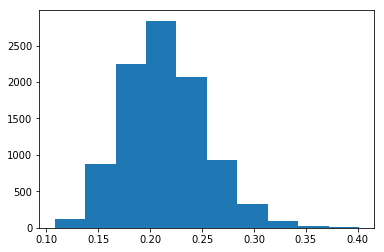

1.9138910850664486


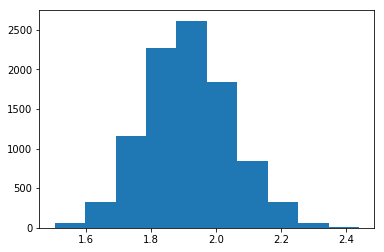

In [66]:
import matplotlib.pyplot as plt

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
print (np.mean(np.exp(samples[:,0])))
plt.hist(np.exp(samples[:,0]))
plt.show()
print (np.mean(np.exp(samples[:,1])))
plt.hist(np.exp(samples[:,1]))
plt.show()

In [64]:
print (distance_abc([0.5 , 1.08497782]) > distance_abc([.2,1.9]))

True
